In [2]:
from Bio import SeqIO
import random
# from numpy import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pysam
import sklearn, hdbscan, random
import pysam
from collections import Counter
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)  
plt.rcParams['figure.dpi'] = 1000

In [298]:
ref_genome_file = "hg19-ch11-HBB.fa"
start = 5245453
end = 5250942
cutsite = 5248230 - start
for record in SeqIO.parse(ref_genome_file, "fasta"):
    HBB_genome =  record.seq
del_min = 200
del_max = 2500
dels_perc = 0.2796705789860646
num_genomes = 10000
dels_number = int(num_genomes * dels_perc)
non_dels_number = num_genomes - dels_number

In [156]:
def func(x):
    return -2.37529158e-04+ 8.32450618 / x


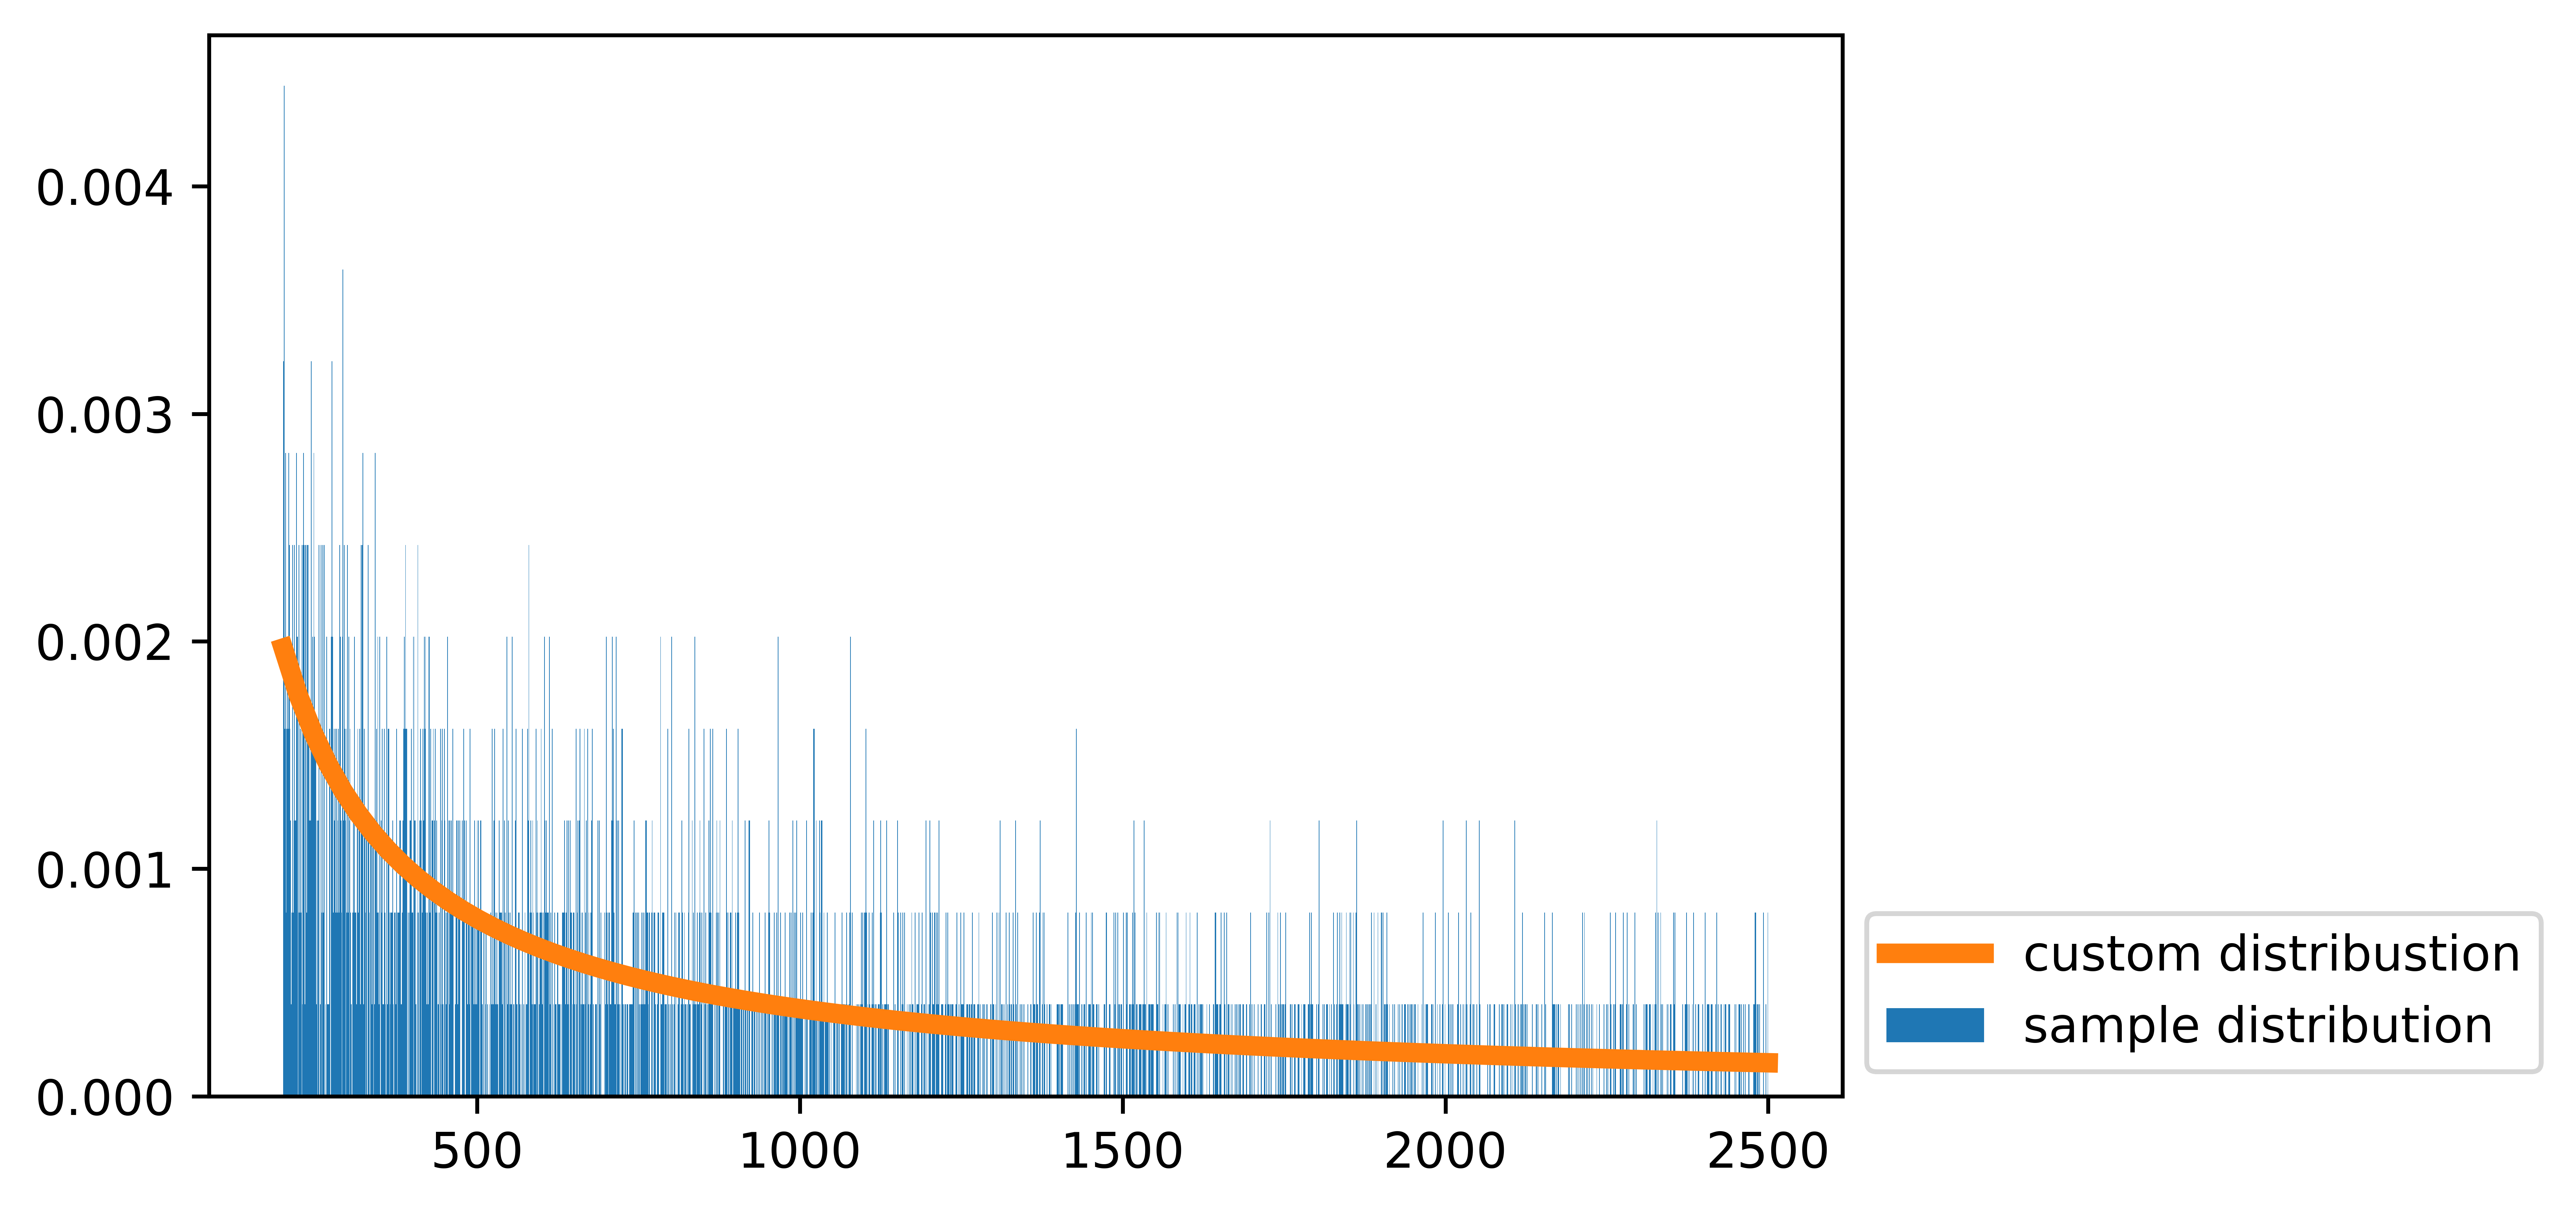

In [259]:
#funtion
def random_custDist(x0,x1,custDist,size=None, nControl=10**6):
    samples=[]
    nLoop=0
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=x0,high=x1)
        prop=custDist(x)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [int(x)]
        nLoop+=1
    return samples

#call
x0=del_min
x1=del_max

    
simulated_del_len_list=random_custDist(del_min,del_max,custDist=func,size=dels_number)

bins=np.linspace(del_min,del_max,int(x1-del_min+1))
hist=np.histogram(samples, bins )[0]
hist=hist/np.sum(hist)
plt.bar( (bins[:-1]+bins[1:])/2, hist, width=.96, label='sample distribution')
#dist
grid=np.linspace(del_min,del_max,100)
discCustDist=np.array([func(x) for x in grid]) #distrete version
discCustDist*=1/(grid[1]-grid[0])/np.sum(discCustDist)
plt.plot(grid,discCustDist,label='custom distribustion', color='C1', linewidth=4)
#decoration
plt.legend(loc=3,bbox_to_anchor=(1,0))
plt.show()

In [320]:
# Random select 25% deletions and put them randomly 
random_simulated_del_num = int(0.25*dels_number)
random_simulated_del_len_list = np.random.choice(simulated_del_len_list, random_simulated_del_num)

# Random select 85% deletions and put them around cutsite
cutsite_simulated_del_num = int(0.75*dels_number)
cutsite_simulated_del_len_list = np.random.choice(simulated_del_len_list, cutsite_simulated_del_num)

In [321]:
# Midpoints range: central +- 0.5 del_length
random_dels_paris = []
for i in random_simulated_del_len_list:
    random_dels_paris.append([i, np.random.randint(cutsite-i/2, cutsite+i/2)])


In [322]:
# Start Stop around cutsite: either a deletion's start is randomly picked 5% around the cutsite, 
# or end is randomly picked 5% around the cutsite
start_stop_around_cutsite = []
for i in cutsite_simulated_del_len_list:
    shift_max = int(0.03*i)
    if shift_max == 0:
        random_shift = cutsite
    else:
        random_shift = np.random.randint(cutsite-shift_max, cutsite+shift_max)
    midpoint_1 = random_shift - int(i/2)
    midpoint_2 = random_shift + int(i/2)
    start_stop_around_cutsite.append([i, np.random.choice([midpoint_1, midpoint_2])])

In [323]:
whole_dels = start_stop_around_cutsite + random_dels_paris

In [324]:
def RedBlueViz(indel):
    plt.xlim(-4000, 4000)
    indelforviz = []
    for i in indel:
        indelforviz.append([i[1] - cutsite, i[0]])
    indelforviz.sort(key=lambda x:x[1])
    for i in range(len(indelforviz)):
        if indelforviz[i][0] <0:
            plt.hlines(i, indelforviz[i][0]-indelforviz[i][1]/2, indelforviz[i][0]+indelforviz[i][1]/2, lw = 0.1, colors="red")
        else:
            plt.hlines(i, indelforviz[i][0]-indelforviz[i][1]/2, indelforviz[i][0]+indelforviz[i][1]/2, lw = 0.1, colors="blue")
    plt.xlabel("Deletion Locations Spanning on Reference")
    plt.ylabel("Read IDs")
    plt.show()

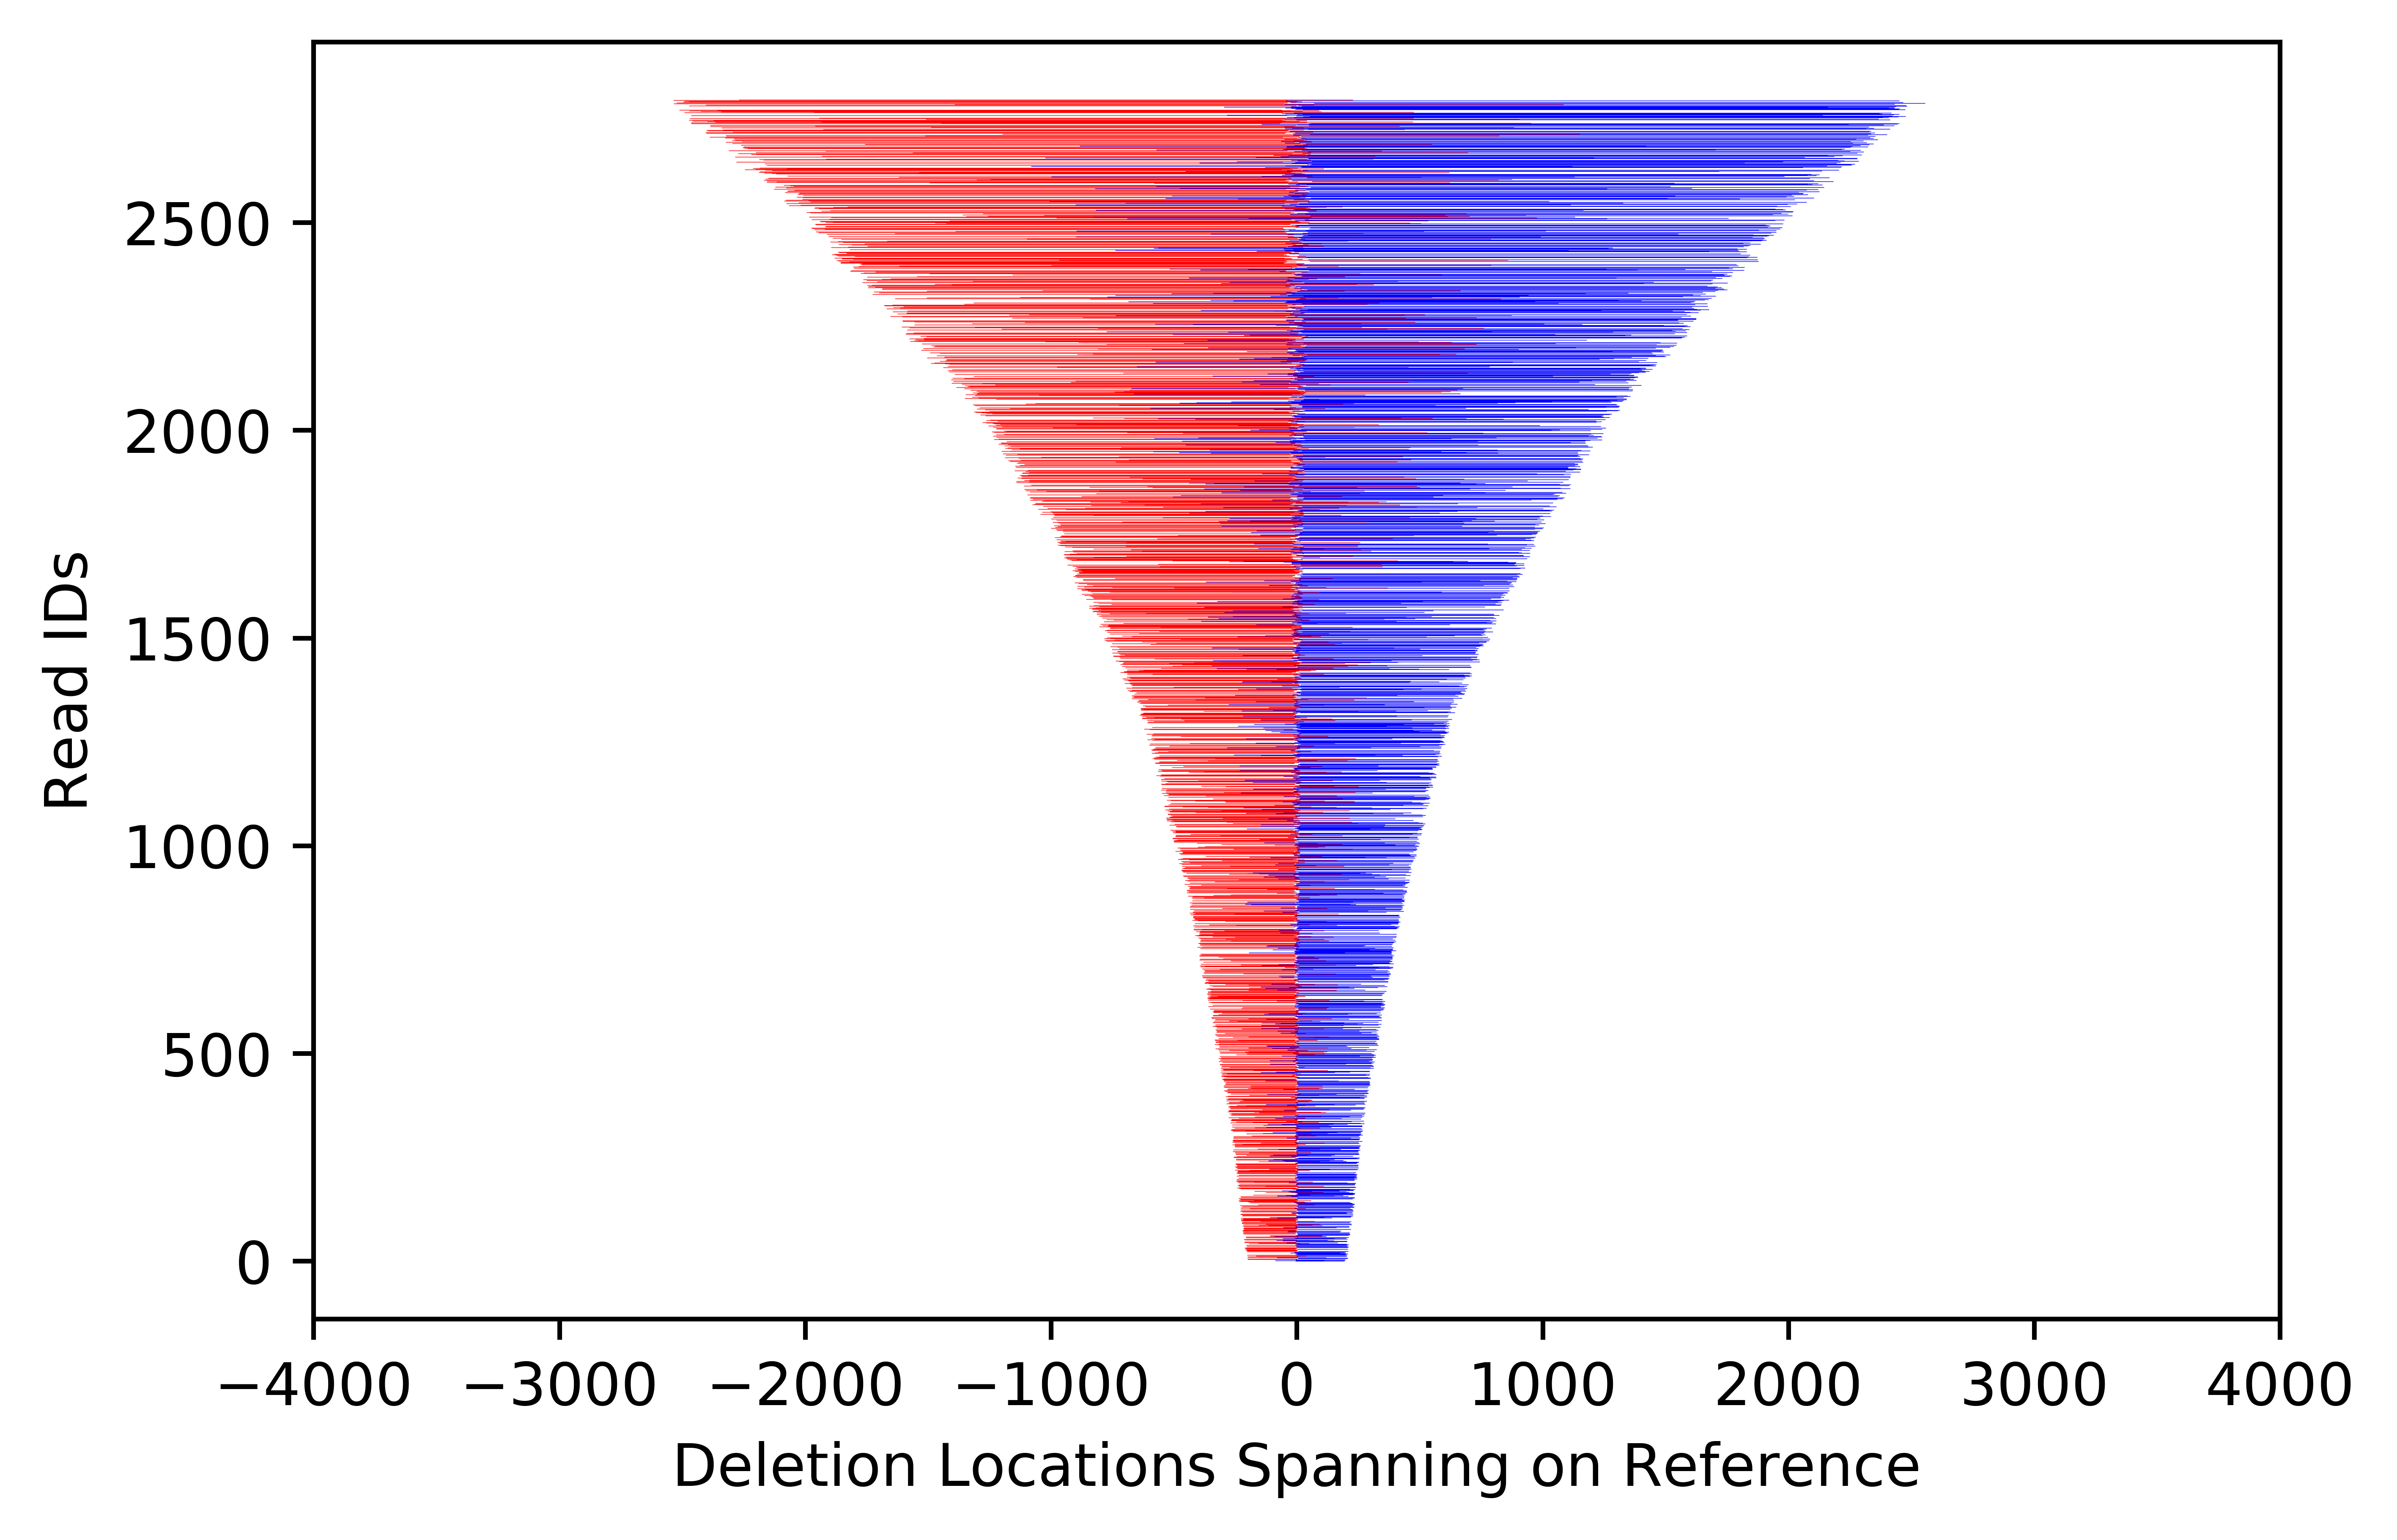

In [325]:
RedBlueViz(whole_dels)

In [307]:
def VizFrequencyChange(indel, readnum):
    locdic = {}
    for i in indel:
        temploc = int(i[0]/100)*100
        if temploc not in locdic:
            locdic.update({temploc:0})
        else:
            locdic[temploc] += 1
    locs =  [str(i) for i in np.array(list(locdic.keys()))]
    loccnts = np.round((np.array(list(locdic.values()))/(readnum/100)), decimals=3)
    fig = go.Figure(data=[go.Bar(x = locs, y=loccnts,text=loccnts,textposition='auto')],)
    fig.update_layout(
        title="Percentage of Deletions in certain length region(Number of Deletion / Number of Reads)",
        xaxis_title="Deletion Lengths",
        yaxis_title="Percentage of Deletions",
        )
    fig.show()


In [308]:
VizFrequencyChange(whole_dels, 2795)

In [316]:
len(whole_dels)

2796

In [310]:
# Add Deletions to Reads
str_HBB_genome = str(HBB_genome)
del_seqs_list = []
for i in whole_dels:
    del_start = i[1] - int(i[0]/2)
    del_end = i[1] + int(i[0]/2)
    del_seqs_list.append(str_HBB_genome[:del_start] + str_HBB_genome[del_end:])

In [311]:
with open("simulation/BC01_simulated_new.fa", "w") as f:
    for i, j in enumerate(del_seqs_list):
        f.writelines(f">S_{i}\n")
        f.writelines(f"{j}\n")
    for i in range(non_dels_number):
        f.writelines(f">S_{i+dels_number}\n")
        f.writelines(f"{str_HBB_genome}\n")


In [313]:
with open("simulation/BC01_simulated_new1.fa", "w") as BC01_sim:
    for record in SeqIO.parse("simulation/BC01_simulated_new.fa", "fasta"):
        SeqIO.write(record, BC01_sim, "fasta")

In [326]:
del_len_list = []
for i in del_seqs_list:
    del_len_list.append(len(i))

In [327]:
min(del_len_list)

2992

In [333]:
samfile_simulated = pysam.AlignmentFile("simulation/test2/BC01_sim_sorted.bam", "rb")
samfile_simulated.check_index()
samfile_simulated_bwa = pysam.AlignmentFile("simulation/test2/BC01_BWA_sorted.bam", "rb")
samfile_simulated_bwa.check_index()

True

In [334]:
reads_simulated = []
for read in samfile_simulated.fetch("NC_000011.9", 5245453, 5250942):
    reads_simulated.append(read)
reads_simulated_bwa = []
for read in samfile_simulated_bwa.fetch("NC_000011.9", 5245453, 5250942):
    reads_simulated_bwa.append(read)


In [336]:
def GetChimercDels(readfromsam):
    SAReads = []
    SAdic = {}
    # os.mkdir("BC01_SA.sam")
    for read in readfromsam.fetch("NC_000011.9", 5245453, 5250942):
        SAReads.append(read)
        if read.has_tag('SA'):
#             for j in read.cigar:
#                 if j[0] == 2 or j[0] == 0:
#                     l += j[1]
            if read.qname not in SAdic:
                if read.is_reverse:
                    SAdic.update({read.qname:[[read.pos, read.pos+read.reference_length, False]]})
                else:
                    SAdic.update({read.qname:[[read.pos, read.pos+read.reference_length, True]]})
            else:
                if read.is_reverse:
                    SAdic[read.qname].append([read.pos, read.pos+read.reference_length, False])
                else:
                    SAdic[read.qname].append([read.pos, read.pos+read.reference_length, True])
    SAlist = []
    for i in SAdic:
        j  = SAdic[i]
        if len(j) == 2:
            if j[0][0] < j[1][0]:
                if j[1][0]- j[0][1] > 200:
                    SAlist.append([j[0][1]-5248230, j[1][0] - j[0][1]])
#                     mixdel.append([j[0][1]-5248230, j[1][0] - j[0][1]])
    #                 print(j[0][1]-5248230, j[1][0] - j[0][1])
            else:
                if j[0][0] - j[1][1] > 200:
                    SAlist.append([j[1][1]-5248230, j[0][0] - j[1][1]])
#                     mixdel.append([j[1][1]-5248230, j[0][0] - j[1][1]])
    return SAlist, len(SAReads)

In [337]:
simulated_chimeric, simulated_chimeric_num = GetChimercDels(samfile_simulated)
simulated_chimeric_bwa, simulated_chimeric_bwa_num = GetChimercDels(samfile_simulated)

In [338]:
def getdelins(readfromsam):
    dels = []
    ins = []
    for i in readfromsam:
        l = 0
        for j in i.cigar:
            if j[0] == 2 and j[1] >= 200:
                dels.append([(l+i.pos)-5248230, j[1]])
            if j[0] == 1 and j[1] > 50:
                ins.append([(l+i.pos)-5248230, j[1]])
            if j[0] == 2 or j[0] == 0:
                l += j[1]
    return (dels, ins)

In [339]:
dels_simulated_bwa, ins_simulated_bwa = getdelins(reads_simulated_bwa)
dels_simulated, ins_simulated = getdelins(reads_simulated)

In [340]:
sim_dels_total = dels_simulated+simulated_chimeric+dels_simulated_bwa+simulated_chimeric_bwa

In [341]:
def DelDistribution(indel):
    dels_lr_1 = []
    dels_lr_2 = []
    for i in indel:
        dels_lr_1.append(i[0]+i[1]/2)
        dels_lr_2.append(i[1])
    plt.figure()
    plt.scatter(x= dels_lr_1, y=dels_lr_2, s=.1,alpha=0.3, label="Profile1")
    plt.xlabel("Deletion Middle Point Locations")
    plt.ylabel("Deletion Lengths")
    plt.legend(fontsize = "xx-small")
    plt.show()

In [342]:
def HDBCluster(min_csize, indel):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_csize)
    dbscan_clusters_labels = list(clusterer.fit_predict(indel))
#     labels = dbscan_clusters
#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    clstrdic = {}
    for j in range(len(dbscan_clusters_labels)):
        if dbscan_clusters_labels[j] != -1:
            if dbscan_clusters_labels[j] not in clstrdic:
                clstrdic.update({dbscan_clusters_labels[j] : [indel[j]]})
            else:
                clstrdic[dbscan_clusters_labels[j]].append(indel[j])
    return clstrdic

In [343]:
def HDBClustersViz(min_csize, indel):
    clstrdic =HDBCluster(min_csize, indel)
    plt.figure()
    plt.axis([-1500,1500,0,5000])
    for i in clstrdic:
        temp_1 = []
        temp_2 = []
        for j in clstrdic[i]:
            temp_1.append(j[0]+j[1]/2)
            temp_2.append(j[1])
        plt.scatter(x=temp_1, y=temp_2, s=0.001)
    plt.xlabel("Deletion Middle Point Locations with HDBSCAN")
    plt.ylabel("Deletion Lengths")
    plt.show()

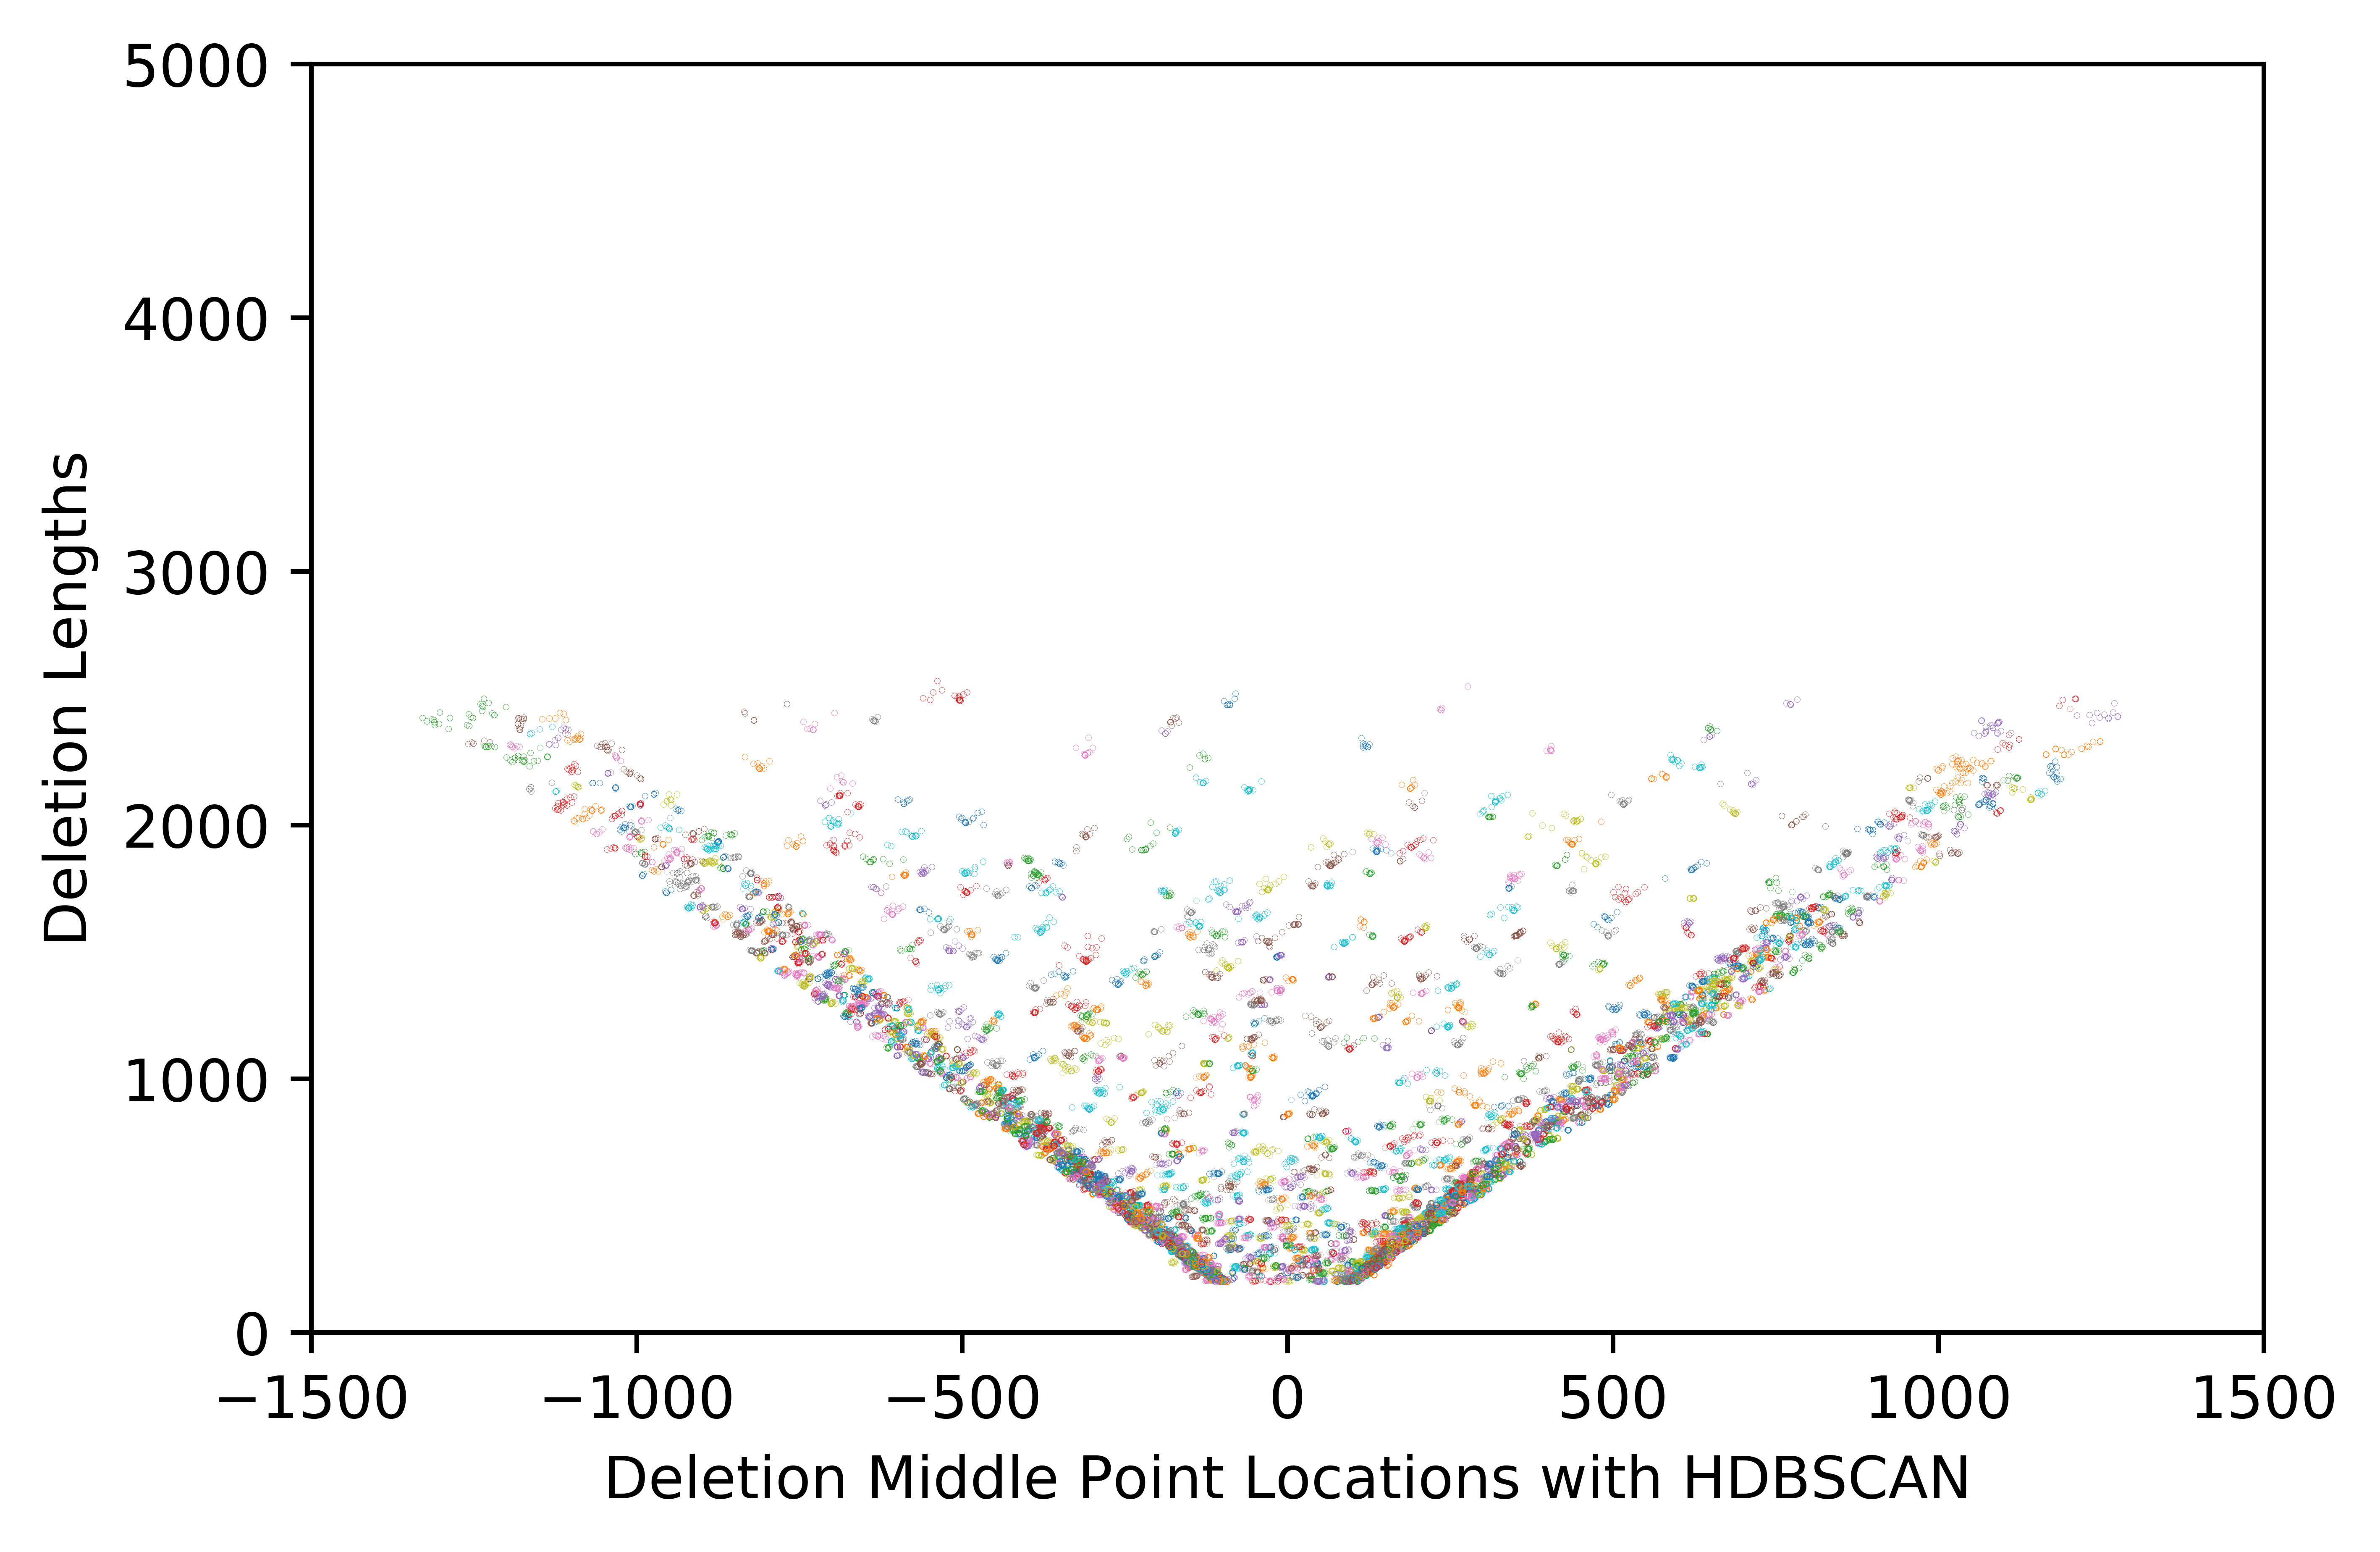

In [344]:
HDBClustersViz(10, sim_dels_total)

In [356]:
def ClusterDelFreqViz(clstrdic_lr, clstrdic_sr, eventnum):

#     clstrdic_lr = HDBCluster(e1, indel1)
#     clstrdic_sr = HDBCluster(e2, indel2)
    dels_lr_cluster_max = []
    for i in clstrdic_lr:
        c_t = tuple(tuple([y for y in x]) for x in clstrdic_lr[i])
        dels_lr_cluster_max.append(Counter(c_t).most_common(1)[0][0])
    dels_sr_cluster_max = []
    for i in clstrdic_sr:
        c_t = tuple(tuple([y for y in x]) for x in clstrdic_sr[i])
        dels_sr_cluster_max.append(Counter(c_t).most_common(1)[0][0])
    dels_lr_cluster_max.sort(key=lambda x:(x[0]))
    locdic = {}
    loccnts=[]
    for i in dels_lr_cluster_max:
        temploc = int(i[1]/100)*100
        if temploc not in locdic:
            locdic.update({temploc:0})
        else:
            locdic[temploc] += 1

    locs =  [str(i) for i in np.array(list(sorted(locdic.keys())))]
    for i in sorted(locdic.keys()):
        loccnts.append(100*locdic[i]/eventnum)
#         loccnts.append(100*locdic[i]/10000)


    dels_sr_cluster_max
    locdic_SR = {}
    loccnts_SR = []
    for i in dels_sr_cluster_max:
        temploc = int(i[1]/100)*100
        if temploc not in locdic_SR:
            locdic_SR.update({temploc:0})
        else:
            locdic_SR[temploc] += 1

    locs_SR =  [str(i) for i in np.array(list(sorted(locdic_SR.keys())))]
    for i in sorted(locdic_SR.keys()):
        loccnts_SR.append(100*locdic_SR[i]/eventnum)


    fig = go.Figure()
    fig.add_trace(go.Bar(x= locs, y=loccnts,  name='Profile Cluster1'))
    fig.add_trace(go.Scatter(x= locs, y=loccnts,  name='Profile Cluster1'))
    fig.add_trace(go.Bar(x= locs_SR, y=loccnts_SR, name='Profile Cluster2'))
    fig.add_trace(go.Scatter(x= locs_SR, y=loccnts_SR, name='Profile Cluster2'))

    fig.update_layout(
        title="Clustered Deletion lengths distribution of the intersection <br> (Number of Deletions / Number Read)",
        xaxis_title="Deletions Lengths",
        yaxis_title="Percentage of Deletions",
        )
    fig.show()

In [369]:
dels_sims_clusters = HDBCluster(9, sim_dels_total)

In [360]:
whole_dels_new = {}
for i, j in enumerate(whole_dels):
    whole_dels_new.update({i: [[j[1] - cutsite, j[0]]]})

In [370]:
ClusterDelFreqViz(dels_sims_clusters, whole_dels_new, 10000)